<a href="https://colab.research.google.com/github/tanderson11/covid_households/blob/main/ParameterInferenceLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter Inference Laboratory

# Drive + Github Configuration

If running for the first time, uncomment the necessary lines to create a token and clone the repository.

You'll have to authenticate on google drive the first time and each time the runtime times out.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%mkdir /content/gdrive/My\ Drive/github
%cd /content/gdrive/My\ Drive/github

mkdir: cannot create directory ‘/content/gdrive/My Drive/github’: File exists
/content/gdrive/My Drive/github


In [ ]:
# Request a token and then add it to the line below and then uncomment both lines
#!echo git_token=\"your_token_here\" > git_token.py
#from git_token import git_token

In [ ]:
repo_owner="tanderson11"
repository="covid_households"

In [ ]:
### UNCOMMENT THIS LINE TO CLONE FOR THE FIRST TIME
#!git clone https://{git_token}@github.com/{repo_owner}/{repository}

In [ ]:
%cd covid_households/
!ls -al

# this will put your token in the right folder; comment this line out after use to avoid error message
#!mv ../git_token.py ./

### UNCOMMENT THIS LINE TO PULL CHANGES
#!git pull

/content/gdrive/My Drive/github/covid_households
total 611
-rw------- 1 root root   1335 Apr 20 16:17 constants.py
-rw------- 1 root root   4144 Apr 20 16:17 forward_simulation.py
drwx------ 2 root root   4096 Apr 20 16:16 .git
-rw------- 1 root root   1450 Apr 21 14:00 .gitignore
-rw------- 1 root root     53 Apr 21 14:04 git_token.py
drwx------ 2 root root   4096 Apr 20 16:42 .ipynb_checkpoints
-rw------- 1 root root  55072 Apr 21 14:00 Lab.ipynb
-rw------- 1 root root    695 Apr 21 13:39 likelihood.py
-rw------- 1 root root  11425 Apr 21 13:45 population.py
drwx------ 2 root root   4096 Apr 20 16:18 __pycache__
-rw------- 1 root root     18 Apr 20 16:17 README.md
-rw------- 1 root root    123 Apr 20 16:28 settings.py
-rw------- 1 root root   8220 Apr 20 16:37 torch_forward_simulation.py
-rw------- 1 root root   1372 Apr 20 16:17 utilities.py
-rw------- 1 root root 511698 Apr 20 16:17 Vaccine.ipynb
-rw------- 1 root root  13659 Apr 21 16:19 vaccine.py


# Initialization

In [ ]:
# Initialization
import importlib
import vaccine
import likelihood
import utilities
import pandas as pd
import numpy as np
import functools
import seaborn as sns
import matplotlib.pyplot as plt

# Reload modules

In [ ]:
importlib.reload(vaccine)
importlib.reload(likelihood)
importlib.reload(utilities)

<module 'utilities' from '/content/gdrive/My Drive/github/covid_households/utilities.py'>

# Experiments

Running study ...
 Vaccine study named mixed vaccinated baseline with:
	n_per_arm                = 500
	household sizes          = {8: 500}
	es, et                   = 0.300, 0.700
	vax_sus, vax_inf         = 0.700, 0.300
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



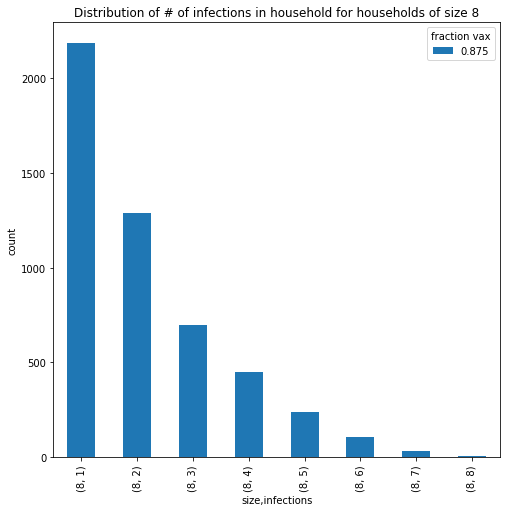

In [26]:
# Model parameters
n_baseline = 500
sizes = [8] # the nhouseholds are divided evenly among the sizes

hsar = 0.20 # the desired household sar when averaged over the sizes of the households
et=0.3
es = 0.7 # Would we prefer another name for this?

#fractions = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]
fractions = [0.875]
#fractions = [0.5]

duration = 90 # days
importation_probability_over_study = 0.075

baseline_dfs=[]
for f in fractions:
    vaccination_method = functools.partial(vaccine.vaccinate_fraction,fraction_vaccinated=f)
    study = vaccine.VaccineStudy("mixed vaccinated baseline", n_baseline, sizes, hsar, es, (et, 'et'), duration, importation_probability_over_study, vaccination_method, seeding=utilities.seed_one_by_susceptibility)
    df, _ = study.run_trials(10, arms='vax')
    df["fraction vax"] = f

    baseline_dfs.append(df)

printer_study = study

baseline_vax_df = pd.concat(baseline_dfs)
utilities.make_bar_chart(baseline_vax_df, color_by_column="fraction vax")

In [27]:
# Likelihood surface with mutiple fractions
sus_axis = np.linspace(0.1, 0.9, 15)
inf_axis = np.linspace(0.1, 0.9, 15)

#sus_axis = np.linspace(0.1, 0.5, 13)
#inf_axis = np.linspace(0.2, 0.9, 19)
print(sus_axis)
print(inf_axis)
trials = 1 # only 1 trial here because we are trying to create one infinitely large simulated population


def inner_df(inf, sus, f, pool_size=15000):
    v_name = "vax_sus={0}, vax_inf={1}".format(sus,inf)
    n_hh = pool_size*len(sizes)
    vaccination_method = functools.partial(vaccine.vaccinate_fraction,fraction_vaccinated=f)

    study = vaccine.VaccineStudy(v_name, n_hh, sizes, hsar, 1-sus, (1-inf, 'et'), duration, importation_probability_over_study, vaccination_method, seeding=utilities.seed_one_by_susceptibility)
    simulated_df, _ = study.run_trials(1, arms='vax')
    return simulated_df


groupings = {"vaxed":["size", "num vaccinated", "vaccinated infected"],
             "unvaxed": ["size", "num vaccinated", "unvaccinated infected"],
             "both vaxed+unvaxed": ["size", "num vaccinated", "vaccinated infected", "unvaccinated infected"]}

from collections import defaultdict
#dfs = defaultdict([]) 

inf_dfs = []
for inf in inf_axis:
    sus_dfs = []
    for sus in sus_axis:
        logls = defaultdict(lambda: [])
        #logls = []
        vaxed_logls = []
        unvaxed_logls = []
        for f in fractions:
            pool_size = 25000
            simulated_df = inner_df(inf, sus, f, pool_size=pool_size)
            
            #if not likelihoods_compatible(baseline_vax_df, simulated_df):
            #    simulated_df = pd.concat([simulated_df, inner_df(inf, sus, f, pool_size=pool_size*2)]) # triple the size of the frequency pool to sample from if the likelihood would have been -inf
            
            baseline_grouped = baseline_vax_df.groupby("trialnum")

            for label,grouping in groupings.items():
                _logl = baseline_grouped.apply(lambda g: likelihood.log_likelihood(grouping, g[g["fraction vax"] == f], simulated_df))
                logls[label].append(_logl)

            #vaxed_grouping = ["size", "num vaccinated", "vaccinated infected"]
            #_logl_only_vaxed = baseline_grouped.apply(lambda g: log_likelihood(vaxed_grouping, g[g["fraction vax"] == f], simulated_df))
            #vaxed_logls.append(_logl_only_vaxed)

            #unvaxed_grouping = ["size", "num vaccinated", "unvaccinated infected"]
            #_logl_only_unvaxed = baseline_grouped.apply(lambda g: log_likelihood(unvaxed_grouping, g[g["fraction vax"] == f], simulated_df))
            #unvaxed_logls.append(_logl_only_unvaxed)

            #both_grouping = ["size", "num vaccinated", "vaccinated infected", "unvaccinated infected"]
            #_logl = baseline_grouped.apply(lambda g: log_likelihood(both_grouping, g[g["fraction vax"] == f], simulated_df))
            #logls.append(_logl)

        for label in groupings.keys():
            logl = sum(logls[label])
            logl = logl.to_frame()
            logl["logl type"] = label
            logl["sus"] = sus

            sus_dfs.append(logl)
        
        #logl = sum(logls)
        #logl = logl.to_frame()
        #logl["logl type"] = "both vaxed+unvaxed"
        #logl["sus"] = sus
        #sus_dfs.append(logl)

        #v_logl = sum(vaxed_logls)
        #v_logl = v_logl.to_frame()
        #v_logl["logl type"] = "vaxed"
        #v_logl["sus"] = sus
        #sus_dfs.append(v_logl)

        #u_logl = sum(unvaxed_logls)
        #u_logl = u_logl.to_frame()
        #u_logl["logl type"] = "unvaxed"
        #u_logl["sus"] = sus
        #sus_dfs.append(u_logl)
        
    sus_df = pd.concat(sus_dfs)#, axis=1)
    sus_df["inf"] = inf
    inf_dfs.append(sus_df)

inf_df = pd.concat(inf_dfs)
inf_df

[0.1        0.15714286 0.21428571 0.27142857 0.32857143 0.38571429
 0.44285714 0.5        0.55714286 0.61428571 0.67142857 0.72857143
 0.78571429 0.84285714 0.9       ]
[0.1        0.15714286 0.21428571 0.27142857 0.32857143 0.38571429
 0.44285714 0.5        0.55714286 0.61428571 0.67142857 0.72857143
 0.78571429 0.84285714 0.9       ]
Running study ...
 Vaccine study named vax_sus=0.1, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.900, 0.900
	vax_sus, vax_inf         = 0.100, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.900
	vax_sus, vax_inf         = 0.157, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.900
	vax_sus, vax_inf         = 0.214, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.900
	vax_sus, vax_inf         = 0.271, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.900
	vax_sus, vax_inf         = 0.329, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.3857142857142858, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.614, 0.900
	vax_sus, vax_inf         = 0.386, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.44285714285714284, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.557, 0.900
	vax_sus, vax_inf         = 0.443, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.5, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.500, 0.900
	vax_sus, vax_inf         = 0.500, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.5571428571428572, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.443, 0.900
	vax_sus, vax_inf         = 0.557, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.6142857142857143, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.386, 0.900
	vax_sus, vax_inf         = 0.614, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.6714285714285715, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.329, 0.900
	vax_sus, vax_inf         = 0.671, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.7285714285714286, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.271, 0.900
	vax_sus, vax_inf         = 0.729, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.7857142857142857, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.214, 0.900
	vax_sus, vax_inf         = 0.786, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.8428571428571429, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.157, 0.900
	vax_sus, vax_inf         = 0.843, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.9, vax_inf=0.1 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.100, 0.900
	vax_sus, vax_inf         = 0.900, 0.100
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.1, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.900, 0.843
	vax_sus, vax_inf         = 0.100, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta         

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.843
	vax_sus, vax_inf         = 0.157, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.843
	vax_sus, vax_inf         = 0.214, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.843
	vax_sus, vax_inf         = 0.271, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.843
	vax_sus, vax_inf         = 0.329, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.3857142857142858, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.614, 0.843
	vax_sus, vax_inf         = 0.386, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.44285714285714284, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.557, 0.843
	vax_sus, vax_inf         = 0.443, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.5, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.500, 0.843
	vax_sus, vax_inf         = 0.500, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.5571428571428572, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.443, 0.843
	vax_sus, vax_inf         = 0.557, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.6142857142857143, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.386, 0.843
	vax_sus, vax_inf         = 0.614, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.6714285714285715, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.329, 0.843
	vax_sus, vax_inf         = 0.671, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.7285714285714286, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.271, 0.843
	vax_sus, vax_inf         = 0.729, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.7857142857142857, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.214, 0.843
	vax_sus, vax_inf         = 0.786, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.8428571428571429, vax_inf=0.15714285714285714 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.157, 0.843
	vax_sus, vax_inf         = 0.843, 0.157
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar       

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.2142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.786
	vax_sus, vax_inf         = 0.157, 0.214
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.2142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.786
	vax_sus, vax_inf         = 0.214, 0.214
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.2142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.786
	vax_sus, vax_inf         = 0.271, 0.214
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.2142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.786
	vax_sus, vax_inf         = 0.329, 0.214
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.3857142857142858, vax_inf=0.2142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.614, 0.786
	vax_sus, vax_inf         = 0.386, 0.214
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.44285714285714284, vax_inf=0.2142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.557, 0.786
	vax_sus, vax_inf         = 0.443, 0.214
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.5, vax_inf=0.2142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.500, 0.786
	vax_sus, vax_inf         = 0.500, 0.214
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.5571428571428572, vax_inf=0.2142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.443, 0.786
	vax_sus, vax_inf         = 0.557, 0.214
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.6142857142857143, vax_inf=0.2142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.386, 0.786
	vax_sus, vax_inf         = 0.614, 0.214
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.6714285714285715, vax_inf=0.2142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.329, 0.786
	vax_sus, vax_inf         = 0.671, 0.214
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar         

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.27142857142857146 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.729
	vax_sus, vax_inf         = 0.157, 0.271
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.27142857142857146 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.729
	vax_sus, vax_inf         = 0.214, 0.271
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.27142857142857146 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.729
	vax_sus, vax_inf         = 0.271, 0.271
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.27142857142857146 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.729
	vax_sus, vax_inf         = 0.329, 0.271
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.3857142857142858, vax_inf=0.27142857142857146 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.614, 0.729
	vax_sus, vax_inf         = 0.386, 0.271
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.44285714285714284, vax_inf=0.27142857142857146 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.557, 0.729
	vax_sus, vax_inf         = 0.443, 0.271
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.5, vax_inf=0.27142857142857146 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.500, 0.729
	vax_sus, vax_inf         = 0.500, 0.271
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.5571428571428572, vax_inf=0.27142857142857146 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.443, 0.729
	vax_sus, vax_inf         = 0.557, 0.271
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.6142857142857143, vax_inf=0.27142857142857146 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.386, 0.729
	vax_sus, vax_inf         = 0.614, 0.271
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar       

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.6714285714285715, vax_inf=0.27142857142857146 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.329, 0.729
	vax_sus, vax_inf         = 0.671, 0.271
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.7285714285714286, vax_inf=0.27142857142857146 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.271, 0.729
	vax_sus, vax_inf         = 0.729, 0.271
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar       

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.3285714285714286 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.671
	vax_sus, vax_inf         = 0.157, 0.329
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.3285714285714286 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.671
	vax_sus, vax_inf         = 0.214, 0.329
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.3285714285714286 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.671
	vax_sus, vax_inf         = 0.271, 0.329
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.3285714285714286 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.671
	vax_sus, vax_inf         = 0.329, 0.329
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.3857142857142858, vax_inf=0.3285714285714286 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.614, 0.671
	vax_sus, vax_inf         = 0.386, 0.329
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.44285714285714284, vax_inf=0.3285714285714286 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.557, 0.671
	vax_sus, vax_inf         = 0.443, 0.329
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.5, vax_inf=0.3285714285714286 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.500, 0.671
	vax_sus, vax_inf         = 0.500, 0.329
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.5571428571428572, vax_inf=0.3285714285714286 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.443, 0.671
	vax_sus, vax_inf         = 0.557, 0.329
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.3857142857142858 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.614
	vax_sus, vax_inf         = 0.157, 0.386
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.3857142857142858 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.614
	vax_sus, vax_inf         = 0.214, 0.386
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.3857142857142858 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.614
	vax_sus, vax_inf         = 0.271, 0.386
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.3857142857142858 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.614
	vax_sus, vax_inf         = 0.329, 0.386
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.3857142857142858, vax_inf=0.3857142857142858 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.614, 0.614
	vax_sus, vax_inf         = 0.386, 0.386
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.44285714285714284, vax_inf=0.3857142857142858 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.557, 0.614
	vax_sus, vax_inf         = 0.443, 0.386
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.5, vax_inf=0.3857142857142858 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.500, 0.614
	vax_sus, vax_inf         = 0.500, 0.386
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.44285714285714284 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.557
	vax_sus, vax_inf         = 0.157, 0.443
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.44285714285714284 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.557
	vax_sus, vax_inf         = 0.214, 0.443
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.44285714285714284 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.557
	vax_sus, vax_inf         = 0.271, 0.443
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.44285714285714284 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.557
	vax_sus, vax_inf         = 0.329, 0.443
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.3857142857142858, vax_inf=0.44285714285714284 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.614, 0.557
	vax_sus, vax_inf         = 0.386, 0.443
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar       

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.44285714285714284, vax_inf=0.44285714285714284 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.557, 0.557
	vax_sus, vax_inf         = 0.443, 0.443
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.5, vax_inf=0.44285714285714284 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.500, 0.557
	vax_sus, vax_inf         = 0.500, 0.443
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.5571428571428572, vax_inf=0.44285714285714284 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.443, 0.557
	vax_sus, vax_inf         = 0.557, 0.443
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     =

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.5 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.500
	vax_sus, vax_inf         = 0.157, 0.500
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.5 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.500
	vax_sus, vax_inf         = 0.214, 0.500
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.5 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.500
	vax_sus, vax_inf         = 0.271, 0.500
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.5 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.500
	vax_sus, vax_inf         = 0.329, 0.500
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.3857142857142858, vax_inf=0.5 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.614, 0.500
	vax_sus, vax_inf         = 0.386, 0.500
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.5571428571428572 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.443
	vax_sus, vax_inf         = 0.157, 0.557
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.5571428571428572 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.443
	vax_sus, vax_inf         = 0.214, 0.557
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.5571428571428572 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.443
	vax_sus, vax_inf         = 0.271, 0.557
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.5571428571428572 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.443
	vax_sus, vax_inf         = 0.329, 0.557
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.3857142857142858, vax_inf=0.5571428571428572 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.614, 0.443
	vax_sus, vax_inf         = 0.386, 0.557
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar         

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.6142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.386
	vax_sus, vax_inf         = 0.157, 0.614
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.6142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.386
	vax_sus, vax_inf         = 0.214, 0.614
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.6142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.386
	vax_sus, vax_inf         = 0.271, 0.614
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.6142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.386
	vax_sus, vax_inf         = 0.329, 0.614
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.3857142857142858, vax_inf=0.6142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.614, 0.386
	vax_sus, vax_inf         = 0.386, 0.614
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.44285714285714284, vax_inf=0.6142857142857143 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.557, 0.386
	vax_sus, vax_inf         = 0.443, 0.614
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar        

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.6714285714285715 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.329
	vax_sus, vax_inf         = 0.157, 0.671
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.6714285714285715 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.329
	vax_sus, vax_inf         = 0.214, 0.671
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.6714285714285715 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.329
	vax_sus, vax_inf         = 0.271, 0.671
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.6714285714285715 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.329
	vax_sus, vax_inf         = 0.329, 0.671
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar        

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.7285714285714286 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.271
	vax_sus, vax_inf         = 0.157, 0.729
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.7285714285714286 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.271
	vax_sus, vax_inf         = 0.214, 0.729
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.7285714285714286 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.271
	vax_sus, vax_inf         = 0.271, 0.729
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.7285714285714286 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.271
	vax_sus, vax_inf         = 0.329, 0.729
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar        

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.7857142857142857 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.214
	vax_sus, vax_inf         = 0.157, 0.786
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.7857142857142857 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.214
	vax_sus, vax_inf         = 0.214, 0.786
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.7857142857142857 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.214
	vax_sus, vax_inf         = 0.271, 0.786
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.7857142857142857 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.214
	vax_sus, vax_inf         = 0.329, 0.786
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar        

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.8428571428571429 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.157
	vax_sus, vax_inf         = 0.157, 0.843
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.8428571428571429 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.157
	vax_sus, vax_inf         = 0.214, 0.843
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.8428571428571429 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.157
	vax_sus, vax_inf         = 0.271, 0.843
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.8428571428571429 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.157
	vax_sus, vax_inf         = 0.329, 0.843
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar        

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.3857142857142858, vax_inf=0.8428571428571429 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.614, 0.157
	vax_sus, vax_inf         = 0.386, 0.843
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.44285714285714284, vax_inf=0.8428571428571429 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.557, 0.157
	vax_sus, vax_inf         = 0.443, 0.843
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar        

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.15714285714285714, vax_inf=0.9 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.843, 0.100
	vax_sus, vax_inf         = 0.157, 0.900
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

Running study ...
 Vaccine study named vax_sus=0.2142857142857143, vax_inf=0.9 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.786, 0.100
	vax_sus, vax_inf         = 0.214, 0.900
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running study ...
 Vaccine study named vax_sus=0.27142857142857146, vax_inf=0.9 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.729, 0.100
	vax_sus, vax_inf         = 0.271, 0.900
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620

Running study ...
 Vaccine study named vax_sus=0.3285714285714286, vax_inf=0.9 with:
	n_per_arm                = 25000
	household sizes          = {8: 25000}
	es, et                   = 0.671, 0.100
	vax_sus, vax_inf         = 0.329, 0.900
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	househol

,0,logl type,sus,inf
trialnum,,,,
0,-inf,vaxed,0.1,0.1
1,-inf,vaxed,0.1,0.1
2,-inf,vaxed,0.1,0.1
3,-inf,vaxed,0.1,0.1
4,-inf,vaxed,0.1,0.1
...,...,...,...,...
5,-1213.353033,both vaxed+unvaxed,0.9,0.9
6,-1222.173026,both vaxed+unvaxed,0.9,0.9
7,-1226.297585,both vaxed+unvaxed,0.9,0.9


In [28]:
grouped = inf_df.groupby(["logl type", "sus", "inf"])
mean_over_trials = grouped.median()
mean_over_trials

0
logl type          sus inf                 
both vaxed+unvaxed 0.1 0.100000        -inf
                       0.157143        -inf
                       0.214286        -inf
                       0.271429        -inf
                       0.328571        -inf
...                                     ...
vaxed              0.9 0.671429 -864.560701
                       0.728571 -887.193635
                       0.785714 -915.661165
                       0.842857 -942.860571
                       0.900000 -970.491194

[675 rows x 1 columns]

In [29]:
df = mean_over_trials.unstack(level=1)

Vaccine study named mixed vaccinated baseline with:
	n_per_arm                = 500
	household sizes          = {8: 500}
	es, et                   = 0.300, 0.700
	vax_sus, vax_inf         = 0.700, 0.300
	seeding                  = <function seed_one_by_susceptibility at 0x7f027d36c0e0>
	duration                 = 90
	net /person import prob  = 0.075
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



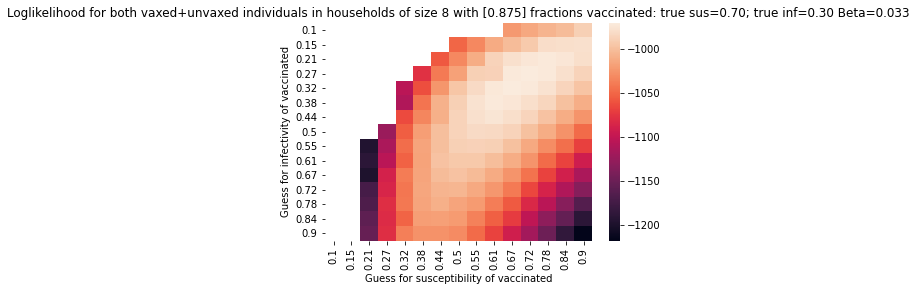

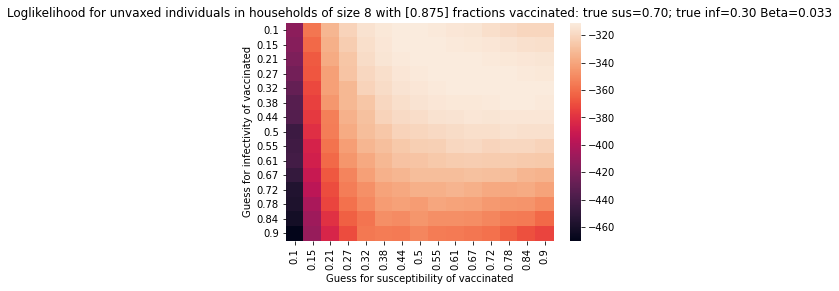

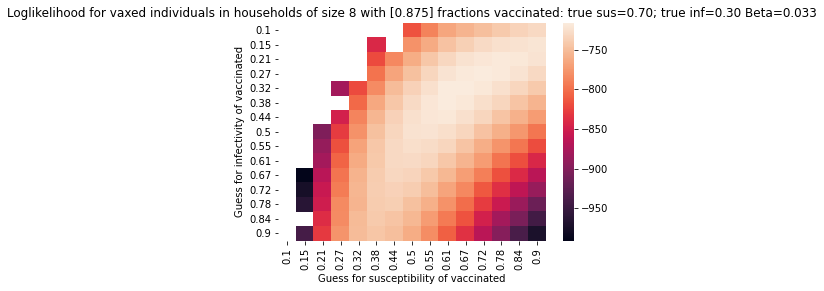

In [30]:
print(printer_study)
for label in sorted(set(df.index.get_level_values(0))):
    table = df.xs(label)
    table = table.replace({-np.inf: np.nan}) # NOTE THIS IS NOT SAFE ALL THE TIME BECAUSE IT SKEWS MEAN TO READ MORE LIKELY DUE TO NANS

    table.index = table.index.astype('str').str.slice(0,4)
    table.columns = table.columns.droplevel(level=0)
    table.columns = table.columns.astype('str').str.slice(0,4)

    sns.heatmap(table, mask=table.isna())
    plt.title("Loglikelihood for {0} individuals in households of size 8 with {1} fractions vaccinated: true sus={2:.2f}; true inf={3:.2f} Beta={4:.3f}".format(label, fractions, 1-es, 1-et, study.household_beta))
    plt.xlabel("Guess for susceptibility of vaccinated")
    plt.ylabel("Guess for infectivity of vaccinated")
    plt.show()

# Making a git commit from changes to python backend

To save this notebook use File > Save a copy in Github

In [31]:
!git add -A
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   utilities.py
	modified:   vaccine.py



In [32]:
!git config --global user.email ""
!git config --global user.email "Thayer"

In [33]:
message = input("Commit message? ")

!git commit -m "{message}"

Commit message? Better vaccine study printouts. Easier configuration of bar charts. 
[main 03265e7] Better vaccine study printouts. Easier configuration of bar charts.
 2 files changed, 33 insertions(+), 9 deletions(-)


# Pushing upstream

In [37]:
!git commit -m "Merged"

[main c101823] Merged


In [38]:
from git_token import git_token

#!git remote set-url origin https://{git_token}@github.com/{repo_owner}/{repository}
!git push

Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 1.31 KiB | 336.00 KiB/s, done.
Total 6 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 3 local objects.
To https://github.com/tanderson11/covid_households
   d5a593e..c101823  main -> main
